In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rambabubevara_tribal_image_classification_path = kagglehub.dataset_download('rambabubevara/tribal-image-classification')

print('Data source import complete.')


### Project: Training and Classifying of Tribal Images into Catgeories

Steps:

- Data Collection & Arranging them into Categorized Folders
- Train-Val-Test Split
- Loading Train & Val Through Image Data Generator
    - Pre-Processing Steps
        - Data Augmentation (if required)
        - Resize
        - Normalization of Images  
- Model Building (CNN+ANN)
- Model Training on Train and Val Generators
- Evaluations
- Predictions on Test
- Real Time Prediction

**0. Images Data**

- Data Taken from Kaggle
- Contains train, val, test folder with each folder having 100 categorized folders and color images
    - Each Image having default size of 224*224
    - Filtered 12 Categories
    

In [ ]:
import shutil
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import os # folders & files operations
import matplotlib.image as mpimg # image read
import matplotlib.pyplot as plt # image display
import os # folders & files operations
import matplotlib.image as mpimg # image read
import matplotlib.pyplot as plt # image display

In [ ]:
# Selecting Kaggle Input Folder for Images

os.chdir('/kaggle/input/tribal-image-classification/Image Classification')

In [ ]:
os.listdir()

['Gadaba', 'Gonds', 'Koya', 'Lambada', 'Chenchu']

## Train,Test,Validation Data

In [ ]:
def train_val_test_split(root_dir=r'/kaggle/input/tribal-image-classification/Image Classification' ,
                         processed_dir='Tribe_split',    # source: one subfolder per classprocessed_dir='Tribes.split',   # destination root
                         test_ratio=0.20,           # fraction of total
                         val_ratio=0.10,            # fraction of total
                         seed=42,                   # for reproducibility
                         overwrite=False            # if True, remove existing processed_dir first
                        ):
    print("########### Train / Val / Test Split started ###########")
    assert 0 < test_ratio < 1 and 0 < val_ratio < 1, "ratios must be in (0,1)"
    assert (test_ratio + val_ratio) < 1, "test_ratio + val_ratio must be < 1"

    # Prepare destination
    if overwrite and os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)

    splits = ['train', 'val', 'test']

    # List class folders only
    classes_dir = [d for d in os.listdir(root_dir)
                   if os.path.isdir(os.path.join(root_dir, d))]

    for cls in classes_dir:
        print(f"$$$ Class Name: {cls} $$$")

        src = os.path.join(root_dir, cls)

        # All files in class folder (skip hidden)
        allFileNames = [f for f in os.listdir(src)
                        if not f.startswith('.')
                        and os.path.isfile(os.path.join(src, f))]

        if len(allFileNames) == 0:
            print(f"⚠️  No files found in {src}, skipping.")
            continue

        # Reproducible shuffle
        rng = np.random.RandomState(seed)
        allFileNames = rng.permutation(np.array(allFileNames))

        n_total = len(allFileNames)
        n_test = int(n_total * test_ratio)
        n_val  = int(n_total * val_ratio)
        n_train = n_total - n_test - n_val

        # Split indices
        test_files  = allFileNames[:n_test]
        val_files   = allFileNames[n_test:n_test + n_val]
        train_files = allFileNames[n_test + n_val:]

        # Report
        print(f"Total images: {n_total}")
        print(f"Training:    {len(train_files)}")
        print(f"Validation:  {len(val_files)}")
        print(f"Testing:     {len(test_files)}\n")

        # Make destination class dirs
        for sp in splits:
            os.makedirs(os.path.join(processed_dir, sp, cls), exist_ok=True)

        # Helper to copy a list of filenames to a split dir
        def _copy_many(file_list, split_name):
            dst_dir = os.path.join(processed_dir, split_name, cls)
            for name in file_list:
                shutil.copy2(os.path.join(src, name), dst_dir)

        _copy_many(train_files, 'train')
        _copy_many(val_files, 'val')
        _copy_many(test_files, 'test')

In [ ]:
train_val_test_split(root_dir=r'/kaggle/input/tribal-image-classification/Image Classification', processed_dir='/kaggle/working/CNNData',overwrite=True)

########### Train / Val / Test Split started ###########
$$$ Class Name: Gadaba $$$
Total images: 192
Training:    135
Validation:  19
Testing:     38

$$$ Class Name: Gonds $$$
Total images: 156
Training:    110
Validation:  15
Testing:     31

$$$ Class Name: Koya $$$
Total images: 222
Training:    156
Validation:  22
Testing:     44

$$$ Class Name: Lambada $$$
Total images: 172
Training:    121
Validation:  17
Testing:     34

$$$ Class Name: Chenchu $$$
Total images: 158
Training:    112
Validation:  15
Testing:     31



In [ ]:
# Checking number of images in folders

for folder in ['/kaggle/working/CNNData/train', '/kaggle/working/CNNData/val', '/kaggle/working/CNNData/test']:
    print("Folder:", folder.title())
    classes = os.listdir("/kaggle/working/CNNData/train")
    for cls in classes:
        print(f"{cls}:", len(os.listdir(folder+"/"+cls)))
    print()

Folder: /Kaggle/Working/Cnndata/Train
Gonds: 110
Gadaba: 135
Lambada: 121
Chenchu: 112
Koya: 156

Folder: /Kaggle/Working/Cnndata/Val
Gonds: 15
Gadaba: 19
Lambada: 17
Chenchu: 15
Koya: 22

Folder: /Kaggle/Working/Cnndata/Test
Gonds: 31
Gadaba: 38
Lambada: 34
Chenchu: 31
Koya: 44



**Loading Train Data & Displaying Sample**

In [ ]:
for category in os.listdir("/kaggle/working/CNNData/train"):
    print("Category:", category)
    print("First Image")
    imgname = os.listdir(f"'/kaggle/working/CNNData/train'/{category}")[0]
    img = mpimg.imread(os.path.join("/kaggle/working/CNNData/train",category,imgname))
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.show()

Category: Gonds
First Image


FileNotFoundError: [Errno 2] No such file or directory: "'/kaggle/working/CNNData/train'/Gonds"

**1. Data Loading - Image Data Generator**

In [ ]:
# Module
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-20 16:31:50.161506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758385910.365993      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758385910.421383      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Taking Train & Validation Images**

In [ ]:
# Defining generators with Data Augmentation : Because We have Small Size Data

train_datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixels to [0,1]
    # Image Data Augmentation Params
    rotation_range=15,     # random rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,  # mirror images
    fill_mode='nearest',   # fill empty pixels after transforms
)

val_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for val/test

In [ ]:
# Create iterators from directory
train = train_datagen.flow_from_directory(
    '/kaggle/working/CNNData/train',
    target_size=(224, 224),   # resize all images
    batch_size=32,            # Number of Images for Batch to Train
    class_mode='categorical', # or 'binary' for 2 classes
    shuffle=True,
    seed=42
)

val = val_datagen.flow_from_directory(
    '/kaggle/working/CNNData/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 605 images belonging to 5 classes.
Found 86 images belonging to 5 classes.


Images as X & Folder/Class Names as y

**Sample X & y View from Train Gen**

In [ ]:
X_batch, y_batch = next(train)   # or: X_batch, y_batch = train_gen.next()
print(X_batch.shape, y_batch.shape)  # (batch_size, H, W, C), (batch_size, num_classes or 1)

(32, 224, 224, 3) (32, 5)


In [ ]:
X_batch[0]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.99991703, 0

In [ ]:
y_batch[0]

array([0., 0., 0., 1., 0.], dtype=float32)

* Above array represents one hot encoding of output column as we have multi class

In [ ]:
train.class_indices

{'Chenchu': 0, 'Gadaba': 1, 'Gonds': 2, 'Koya': 3, 'Lambada': 4}

**2. Model Building**

* Building CNN (to Extract Image Features) +ANN (Classification) Architecture
    * Below are the layers for each Network
    * CNN
        * Convolution Layer
        * Pooling Layer
        * Flatten Layer
    * ANN @ Fully Connected Layer
        * Hidden Layers
        * Output Layer

* **Model Architecture Flow:**
    - Convolutional Layers followed by MaxPooling Layers.
    - The Flatten layer to flatten the output of the convolutional layer.
    - Then we will have fully connected layers followed by the output of the flattened layer.
    - The final layer is the output layer which has the activation function softmax, gives each class prob.
        
    Note: To handle Overfitting , we can given kernel regularizer parameter (l1 or l2) or dropout layers

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Flatten, Dense

**Model Intialization**

In [ ]:
model = Sequential(name="TribeImageClassification")

**2.1 CNN Layers**

**Convolution Layer + Activation**
* Convolution of image with different filters
    params: filters, kernel_size, stride size, input shape

    Note:
    * Padding is another param where we can send the original image size through the entire convolution , it will add an extra pixel to the input image

    * relu is used to deal with non-linearity in the convolution

In [ ]:
model.add(Conv2D(32, kernel_size=(3,3), strides=(2,2), input_shape=(224,224,3), name="Conv1"))
model.add(Activation('relu'))
model.summary()

I0000 00:00:1758385952.915778      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758385952.916465      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

* Output image size = (w-f+2p/s)+1

        here w(width) = 224, f(kernel_size) = 3, p(padding) = 0 (used to balance filter on image), s(stride) = 2

        applying above we will get 111*111*32

* weights/params = ((kernel_size x previous filters) x current filters) + bias (no of current filters)

            kernel_size = (3,3)
            previous filters = 3 (channels)
            current filters = 32
            bias = 32

    total - 896

**Pooling**

* Getting max pixel values from convolution feature maps

    params: pool_size, strides

In [ ]:
model.add(MaxPool2D((2,2), strides=(2,2), name="Pool1"))

In [ ]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

* output image size = (w-f/s)+1

      here w(width) = 63, f(kernel_size) = 2, s(stride) = 2

      applying above we will get 31*31*32

* no weights & biases

**Adding Extra Convolution+Pooling Layer (Optional) - To control the Flatten Output**

In [ ]:
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), name='Conv2'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool2'))

In [ ]:
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), name='Conv3'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool3'))

In [ ]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,600 (100.00 KB)

 Trainable params: 25,600 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

* **Flatten Layer**

In [ ]:
model.add(Flatten(name='Flatten'))

In [ ]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9216)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,600 (100.00 KB)

 Trainable params: 25,600 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

**2.2 ANN (Fully Connected Layer) with Output**
                                       (Input: Flatten)

In [ ]:
# Following Dense Layer Thumb Rule: n/2 -> Flatten/2
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=4096, name='HiddenLayer1'))
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=2048, name='HiddenLayer2'))
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=1024, name='HiddenLayer3'))
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=512, name='HiddenLayer4'))

In [ ]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer1 (Dense)            │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer2 (Dense)            │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer3 (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer4 (Dense)            │ (None, 512)            │       524,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,792,064 (186.13 MB)

 Trainable params: 48,792,064 (186.13 MB)

 Non-trainable params: 0 (0.00 B)

**Output Layer**

In [ ]:
# we have 5 classes in output , softmax will give each class probability

model.add(Dense(kernel_initializer='random_uniform', activation='softmax', units=5, name='OutputLayer'))
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer1 (Dense)            │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer2 (Dense)            │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer3 (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer4 (Dense)            │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,794,629 (186.14 MB)

 Trainable params: 48,794,629 (186.14 MB)

 Non-trainable params: 0 (0.00 B)

**2.3 Compile Params**

In [ ]:
# Compile Params

model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

# We can also Try with different optimizers

**3. Model Training**

* We can use Call Backs [Model CheckPoints, EarlyStopping] if needed

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

ES = EarlyStopping(
    monitor='val_loss', # Same as the
    patience=5, # Wait for 5 epochs before stopping the training
    verbose=1,
    restore_best_weights='True', # Restore model weights from the epoch with the best value of the monitored quantity.
    min_delta=0.1
)

MC = ModelCheckpoint(
    '/kaggle/working/SportsImageClassify_Best.h5', # We can also provide full path to the folder to save model
    monitor='val_loss',  # Monitor other things like val_accuracy or accuracy
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)

In [ ]:
# Taking fit method
# Takes time to run based on number of parameter training

import warnings
warnings.filterwarnings("ignore")

model.fit(train, validation_data=val, epochs=50, callbacks=[ES,MC])

# No need of ytrain/ytest , because image data generator takes class names from given images folder names
# Workers parameter will uses avaiable cores in cpu: workers=-1 means consider all cores available for faster execution

Epoch 1/50


I0000 00:00:1758386011.984310     113 service.cc:148] XLA service 0x799b0c007510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758386011.985306     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758386011.985324     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758386012.382009     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/19 ━━━━━━━━━━━━━━━━━━━━ 2:12 7s/step - accuracy: 0.2812 - loss: 1.6102

I0000 00:00:1758386015.402085     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.2226 - loss: 2.0619
Epoch 1: val_loss improved from inf to 1.58837, saving model to /kaggle/working/SportsImageClassify_Best.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 765ms/step - accuracy: 0.2235 - loss: 2.0485 - val_accuracy: 0.2558 - val_loss: 1.5884
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.2411 - loss: 1.6012
Epoch 2: val_loss improved from 1.58837 to 1.48673, saving model to /kaggle/working/SportsImageClassify_Best.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 603ms/step - accuracy: 0.2421 - loss: 1.6004 - val_accuracy: 0.3256 - val_loss: 1.4867
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3007 - loss: 1.5838
Epoch 3: val_loss improved from 1.48673 to 1.48450, saving model to /kaggle/working/SportsImageClassify_Best.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 591ms/step - accuracy: 0.3000 - loss: 1.5834 - val_accuracy: 0.4302 - val_loss: 1.4845
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.3

**Training Visualization**

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

title="Training Curves"
smooth=None

# Accept History or plain dict
hist = model.history.history if hasattr(model, "history") else history

# Handle metric key variants
acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

# Extract series
acc = list(hist.get(acc_key, []))
val_acc = list(hist.get(val_acc_key, []))
loss = list(hist.get("loss", []))
val_loss = list(hist.get("val_loss", []))
epochs = list(range(1, max(map(len, [acc, val_acc, loss, val_loss])) + 1))

# Optional EMA smoothing
def ema(xs, alpha):
    if not xs or smooth is None: return xs
    out = [xs[0]]
    for x in xs[1:]:
        out.append(alpha * x + (1 - alpha) * out[-1])
    return out

if smooth is not None:
    acc = ema(acc, smooth)
    val_acc = ema(val_acc, smooth)
    loss = ema(loss, smooth)
    val_loss = ema(val_loss, smooth)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Accuracy", "Loss"),
    horizontal_spacing=0.12
)

# Accuracy panel
if acc:
    fig.add_trace(go.Scatter(x=epochs[:len(acc)], y=acc, mode="lines+markers",
                             name="Train Acc"), row=1, col=1)
if val_acc:
    fig.add_trace(go.Scatter(x=epochs[:len(val_acc)], y=val_acc, mode="lines+markers",
                             name="Val Acc"), row=1, col=1)

# Loss panel
if loss:
    fig.add_trace(go.Scatter(x=epochs[:len(loss)], y=loss, mode="lines+markers",
                             name="Train Loss"), row=1, col=2)
if val_loss:
    fig.add_trace(go.Scatter(x=epochs[:len(val_loss)], y=val_loss, mode="lines+markers",
                             name="Val Loss"), row=1, col=2)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.update_layout(
    title=dict(
        text=title,
        y=0.98,              # keep title near the very top
        x=0.5,               # center align
        xanchor="center",
        yanchor="top"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,              # just below title
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=120, r=20, b=40, l=60),  # give enough space
    height=450
)
fig.show()

**Notes:**
* We can tune model performance by
    - Hyp Param Tuning (conv+pool layers adding, filters, kernel sizes, strides, ANN Hidden Layers, etc..)
    - Dropout layers
    - Regularizations
    - Epochs, Batch Size Tuning

**4. Test Predictions**
- Loading Test Images for Predictions

In [ ]:
# Using Validation generator for Images Loading

test =  val_datagen.flow_from_directory(
    '/kaggle/working/CNNData/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predicitons on Loaded Images
predictions = model.predict(test) # Will generate probabilities of 5 classes for each image

Found 168 images belonging to 5 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step


In [ ]:
classes = {v: k for k, v in train.class_indices.items()} # Taking Class Names for Indexes

import numpy as np

output = []
# Going thorugh each images probabilities and identifying max prob class
for prediction in predictions:
    # Mapping high probability class index number with class name
    cls = classes[np.argmax(prediction)]
    output.append(cls)

print(output)

['Lambada', 'Lambada', 'Gadaba', 'Koya', 'Koya', 'Lambada', 'Chenchu', 'Koya', 'Chenchu', 'Koya', 'Chenchu', 'Koya', 'Koya', 'Koya', 'Koya', 'Chenchu', 'Chenchu', 'Koya', 'Chenchu', 'Koya', 'Koya', 'Chenchu', 'Chenchu', 'Chenchu', 'Chenchu', 'Gadaba', 'Gadaba', 'Gonds', 'Lambada', 'Chenchu', 'Gadaba', 'Gadaba', 'Gadaba', 'Lambada', 'Gonds', 'Gadaba', 'Gadaba', 'Gadaba', 'Gadaba', 'Gadaba', 'Gadaba', 'Chenchu', 'Gadaba', 'Gadaba', 'Gadaba', 'Koya', 'Koya', 'Koya', 'Gadaba', 'Gadaba', 'Koya', 'Gadaba', 'Gadaba', 'Gadaba', 'Gadaba', 'Lambada', 'Gadaba', 'Gadaba', 'Gadaba', 'Gonds', 'Gadaba', 'Gadaba', 'Gadaba', 'Gadaba', 'Lambada', 'Gadaba', 'Gadaba', 'Lambada', 'Lambada', 'Gadaba', 'Gadaba', 'Koya', 'Chenchu', 'Lambada', 'Koya', 'Chenchu', 'Lambada', 'Lambada', 'Lambada', 'Lambada', 'Chenchu', 'Chenchu', 'Chenchu', 'Gadaba', 'Chenchu', 'Gonds', 'Chenchu', 'Chenchu', 'Gadaba', 'Lambada', 'Lambada', 'Gonds', 'Lambada', 'Lambada', 'Gadaba', 'Chenchu', 'Gadaba', 'Chenchu', 'Chenchu', 'Gadaba

**5. Real time Prediction**
   * **Prediction on given Images**

In [ ]:
# Writing a Function for prediction of given image

import cv2
import numpy as np

def classify(frame):
    # Converting Image Size to Cnn Input Size
    img=cv2.resize(frame,(224,224))

    #scaling to 0 to 1 range
    if(np.max(img)>1):
        img = img/255.0

    img = np.array([img])
    prediction = model.predict(img)[0] # will predict 12 classes probabilities
    # Taking Class Names & Numbers for Prediction from train data generator
    classes = {v: k for k, v in train.class_indices.items()}
    # mapping high probability class index number with class name
    cls = classes[np.argmax(prediction)]

    return cls # output class name

* **Taking Sample Images from Test Images given**

In [ ]:
import glob

images = glob.glob("/kaggle/input/tribal-image-classification/Image Classification/Gadaba/5906717223_af333c2b24_b.jpg")

In [ ]:
images

['/kaggle/input/tribal-image-classification/Image Classification/Gadaba/5906717223_af333c2b24_b.jpg']

* **Applying above detect function on Images**

Given Image:



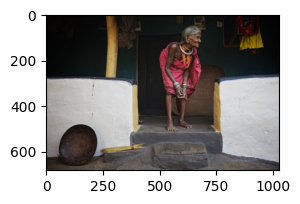


Original Class: 5906717223_af333c2b24_b
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
Prediction Class: Gadaba



In [ ]:
import matplotlib.image as mpimg # to read image in array

# Looping through each image and applying classify function
for img in images:
    # Reading image
    image = mpimg.imread(r'{}'.format(img))
    print("Given Image:")
    print()
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    print()
    print("Original Class:",img.split("/")[-1].split(".")[0])
    out = classify(image) # prediction function
    print("Prediction Class:",out.title())
    print()
    print("=================================================================")

**6. Saving Model For Model Deployment**

**In the callbacks, Best Model with Best Validation Score will be stored in kaggle/working**

- Click on file to download , wait for some time to show download

In [ ]:
#### To save without callbacks

model.save("/kaggle/working/SportsImageClassify.h5") # Keras trained model will have save method